In [1]:
targetHeightToUse                = 110
referencePoolCombination         = [110]
shortOrLong                      = 'S'      # Default 'S'hort uses ONE FILE; 'L'ong EVERY FILE.
maskNumber                       = 2        # Default maskNumber = 2
userTestingNumberFrames          = 3        # Default userTestingNumberFrames = 3
VL                               = 0        # Default very verbose
# ( VL 0 Minimal ; VL 3 verbose and diagnostic, for development; VL 4 debugging / exhaustive / intensive, at pixel value level )

userLabel                        = "label"  # User determined for now
targetName                       = "target" # User determined for now
dynMask4ple                      =  ( False , 0 , 0 , 0 )
runWedgeDecided                  = "A" # Default at least for the MinTest, MedTest, TypTest

KEEP THIS ACKNOWLEDGEMENT BELOW THE VERY TOP / VERY FIRST CELL

OR ELSE THE MASTER WORKER LINK IS BROKEN

Open Source Code : https://pyklip.readthedocs.io/en/latest/

Open Source Code : https://github.com/seawander/centerRadon

In [2]:
import time
import glob
import os
from prntfFunction import prntf
from datetime import datetime
folderDateTimeStamp = time.strftime(       "%H%M%S")
folderString        = folderDateTimeStamp # This can be improved later. For now, it is a minimum and unique.
outputFolder        = "Runs/"+ folderString +"_"+ userLabel +"_"+ targetName + "/"
os.makedirs ( outputFolder )
runPyklipStart      = datetime.now()
t                   = datetime.now().time()
s                   = t.strftime('%H:%M:%S.%f')
r                   = s[:-7]
prntf("work",20,"####################################################################")
prntf("work",20,"# B E G I N   W O R K E R   R U N _ P Y K L I P                    #")
prntf("work",20,"# B E G I N   W O R K E R   R U N _ P Y K L I P                    #")
prntf("work",20,"# Wall clock start time          : ", r                              )
prntf("work",20,"# folderDateTimeStamp            : ", folderDateTimeStamp            )
prntf("work",20,"# targetHeightToUse              : ", targetHeightToUse              )
prntf("work",20,"# referencePoolCombination       : ", referencePoolCombination       )
prntf("work",20,"# shortOrLong                    : ", shortOrLong                    )
prntf("work",20,"# maskNumber                     : ", maskNumber                     )
prntf("work",20,"# userTestingNumberFrames        : ", userTestingNumberFrames        )
prntf("work",20,"# outputFolder                   : ", outputFolder                   )
prntf("work",20,"####################################################################")    

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:101% !important; }</style>"))

In [4]:
approvedFlag            = False # Do this for first  runs when there is no prior list of approved frames.
zeroDataset_PAsFlag     = True  # On first run, yes, zero the PAs in order to get widescreen stddev
zeroOutputFrames_wcsOrientatFlag = False # On first run, no, do not zero the outputFrames wcsOrientat values
radonFlag               = True    
DatasetPlotFlag         = False


if approvedFlag        == False and radonFlag == True  : runNumberString     = "yRC1_" # yes radonCenter
if approvedFlag        == True  and radonFlag == True  : runNumberString     = "yRC2_"
    
# S E T   A P P R O V E D   F R A M E   T H R E S H O L D 
percentileThreshold     = 90  # Top 90% means the 90% of all frames that have the lowest frame stddev


# S E T   R E S I D U A L S   P L O T   F L A G 
OutFrPlotFlag           = True      # Yes,       plot NMF residuals of all *incoming files

                            
userDQmax = 0
userDQmax = 128
# userDQmax = 256
# userDQmax = 512
# userDQmax = 1024
# userDQmax = 2048
# userDQmax = 4096
# userDQmax = 8192
userDQmax = 16384 # nmf_imaging cannot process nans, and having DQmax set at 128 will cause nans 

In [5]:
# This cell is necessary for development, to switch between Anaconda and HPC environment.
# It can be ignored.

HPCENVFlag              = True  # HPC local github install / production
# HPCENVFlag              = False # Anaconda pip packages / diagnostic development
import getpass
# S E T   U S E R   N A M E 
username                = "zyx" # test user extant, and default
username                = "xyz" # test user non-existent
username                = "rmt1"
if HPCENVFlag :
    username            = getpass.getuser()
if VL >= 3 : prntf("work",20,username) # Comment this out at home
 
import sys

# on home computer, it's "/Users/rmt/".
# Change that to "../../"
if VL >= 4 :
    import pkgutil
    #search_path = ['.'] # set to None to see all modules importable from sys.path
    search_path = ['../../Python/pyklip/pyklip/'] # set to None to see all modules importable from sys.path
    all_modules = [x[1] for x in pkgutil.iter_modules(path=search_path)]
    prntf("work",20,all_modules)
    prntf("work",20,)
    prntf("work",20,)

    for i in sys.path :
        prntf("work",20,"native0: \t\t", i)
    prntf("work",20,)
    prntf("work",20,)

if HPCENVFlag == True :              # IF YOU'RE IN THE HPC ENV EMULATOR
    sys.path.insert(0,'../../Python/')
    sys.path.insert(0,'../../Python/nmf_imaging/')   
    sys.path.insert(0,'../../Python/NonnegMFPy/')
    sys.path.insert(0,'../../Python/pyklip/')

else :                               # IF YOU'RE IN ANACONDA DEV
    sys.path.append('../../opt/anaconda3/lib/python3.7/site-packages/nmf_imaging_pkg/src/package/')
    
if VL >= 4 :
    for i in sys.path :
        prntf("work",20,"update4: \t\t", i)
    prntf("work",20,)
    prntf("work",20,)
    import pkgutil
    #search_path = ['.'] # set to None to see all modules importable from sys.path
    search_path = ['../../Python/pyklip/pyklip/'] # set to None to see all modules importable from sys.path
    all_modules = [x[1] for x in pkgutil.iter_modules(path=search_path)]
    prntf("work",20,all_modules)

In [6]:
import os
import math
# import tracemalloc
import numpy as np
# from shutil import copyfile
# import traceback
import importlib
import copy
from datetime import datetime

from astropy.io import fits
from astropy.nddata import Cutout2D # may be ported into class
from astropy.utils.data import download_file
from astropy.utils.data import get_pkg_data_filename
from astropy import stats
from pyklip.instruments.Instrument import GenericData # Not in run_nmf_imaging.ipynb
import pyklip.klip as klip
import pyklip.parallelized as parallelized
import pyklip.rdi as rdi
import pyklip.fakes as fakes
import pyklip.instruments.STIS as STIS
# importlib.reload(parallelized)
# importlib.reload(STIS)
# importlib.reload(klip)

In [7]:
if maskNumber            == 1:
    yesApplyFileMaskFlag  = False
if maskNumber            == 2:
    yesApplyFileMaskFlag  = True
    fileMaskFilename      = "mask_narrow.fits" # 109 rows x 23 columns
    fileMaskLetter        = "NarMask_"
    fileMaskWedgeCode     = "A10"
if maskNumber            == 3:
    yesApplyFileMaskFlag  = True
    fileMaskFilename      = "mask_medium.fits" # 109 rows x 23 columns
    fileMaskLetter        = "MedMask_"
    fileMaskWedgeCode     = "A10"    
if maskNumber            == 4:
    yesApplyFileMaskFlag  = True
    fileMaskFilename      = "mask_wide.fits" # 109 rows x 23 columns
    fileMaskLetter        = "WidMask_"
    fileMaskWedgeCode     = "A10"    
if maskNumber            == 5:
    yesApplyFileMaskFlag  = True
    fileMaskFilename      = "mask_401.fits" # duplicate of "mask_401_-EPS-ERI.fits"
    fileMaskLetter        = "401Mask_"
    fileMaskWedgeCode     = "A10"    


# S E T   D I V E R T   M A S K   F L A G   T O   F A L S E   F O R   P Y K L I P 
divertFileMaskFlag        = False  # Pyklip requires False. NMF requires True.
                            # Diverts application of mask FROM SCI and REF frames TO the dataset member,
                            # where it can be accessed by NMF, which requires a fresh, dedicated mask.
        
if yesApplyFileMaskFlag  == False : divertFileMaskFlag = False
                            # If User does not want to apply mask, then User doesn't need to save mask to dataset member.

# S E T   M A S K
fileMaskHome              = os.path.curdir
fileMaskPath              = fileMaskHome + "/inputmasks/"

if yesApplyFileMaskFlag  == False :
    fileMaskLetter        = "NotMask_"
    fileMaskFQPN          = ""
else:    
    fileMaskFQPN          = fileMaskPath + fileMaskFilename

In [8]:
# S E T   I N P U T   F I L E S 

datapath                    = ""
fileFormat                  = "_flt"  # User sets this to "*" to stop filtering
fileExtension               = ".fits" # User sets this to "*" to stop filtering

filelistRef1                = []

userOutputPrefix            = ""
referenceHeightPrefix       = ""


if targetHeightToUse       == 110 :
    targetHeightPrefix      = "0110"
    targetPath              = datapath + "A10_110_EPSERI_TRG/"
    targetPrefix            = "odn30"
    if shortOrLong         == 'S' :        
        wildcard1           = "5020"
#         wildcard1           = "50"
    if shortOrLong         == 'L' :                
        targetPrefix        = "*"
        wildcard1           = "*" 
if 110 in referencePoolCombination :         
    referenceHeightPrefix   = referenceHeightPrefix + "V"    
    referencePath           = datapath + "A10_110_DELERI_REF/"    
    if shortOrLong         == 'S' :       
        referencePrefix     = "odn30" 
        wildcard3           = "8020" 
#         wildcard3           = "80" 
    if shortOrLong         == 'L' :       
        referencePrefix     = "*"
        wildcard3           = "*" 
    filelistRef1.append (glob.glob ( referencePath + referencePrefix + wildcard3 + "*" + fileFormat + fileExtension )  )

input_planet_fluxes         = [    2e-5,     1e-5,    0.5e-5,    0.25e-5 ]

userOutputPrefix            = runNumberString
    
filelistTrg                 = glob.glob ( targetPath   + targetPrefix + wildcard1 + "*" + fileFormat + fileExtension )
filelistTrg.sort()

filelistRef2 = []
for j in range(len(filelistRef1) ):
    for i in range(len(filelistRef1[j]) ):
        filelistRef2.append(filelistRef1[j][i])
filelistRef1.clear()        
filelistRef2.sort()

In [9]:
usertrgSCIListrefSCIList  = [ filelistTrg , filelistRef2 ]

corr_matrix_fits_filename = outputFolder + userOutputPrefix + "cm.fits"
prntf("work",20,"corr_matrix_fits_filename : ", corr_matrix_fits_filename)

userFinal_yExtent         =  427 # 427 is A10's maximum vertically symmetric rows 
userFinal_yExtent         =  110
userFinal_yExtent         = targetHeightToUse
userFinal_xExtent         = userFinal_yExtent
userFinal_xExtent         = 1024 # 1024 is 50CORON's default width

if runWedgeDecided == "B" :
    userFinal_yExtent = 1044
if VL >= 3 : 
    prntf("work",20,"usertrgSCIListrefSCIList[0]         : ")
    for i in usertrgSCIListrefSCIList[0]:
        prntf("work",20,i)
    prntf("work",20,)

    prntf("work",20,"usertrgSCIListrefSCIList[1]         : ")
    for i in usertrgSCIListrefSCIList[1]:
        prntf("work",20,"[", i, "]")
    prntf("work",20,)

    prntf("work",20,"len ( usertrgSCIListrefSCIList[0] ) : ", len ( usertrgSCIListrefSCIList[0] ) )   
    prntf("work",20,"len ( usertrgSCIListrefSCIList[1] ) : ", len ( usertrgSCIListrefSCIList[1] ) )  
    prntf("work",20,"userFinal_yExtent                   : ", userFinal_yExtent                   )
    prntf("work",20,"userFinal_xExtent                   : ", userFinal_xExtent                   )

work      4  corr_matrix_fits_filename :  Runs/182201_label_target/yRC1_cm.fits            


In [10]:
# S E T   I N N E R   W O R K I N G   A N G L E   and   O U T E R   W O R K I N G   A N G L E

# These are required by the pyklip Instrument class, which are not used by nmf_imaging.
# These are required even if we are not immediately doing planet injection.
# They will still need to be sent in even in the run_nmf_imaging notebook.

userSettingDatasetIWA =   10
userSettingDatasetOWA =  200 

In [11]:
pixelsfilename                   = "pixelCountFile"
pixelsfqpn                       = outputFolder + pixelsfilename  
uniquePixelsIngestedThisSession  = 0
uniquePixelsProcessedThisSession = 0

In [12]:
dataset1 = STIS.STISData   (
                            trgSCIListrefSCIList    = usertrgSCIListrefSCIList ,
                            outputFolder            = outputFolder             ,
                            xExtent                 = userFinal_xExtent        ,
                            yExtent                 = userFinal_yExtent        ,
                            IWA                     = userSettingDatasetIWA    ,
                            OWA                     = userSettingDatasetOWA    ,
                            yesApplyMaskFlag        = yesApplyFileMaskFlag     ,
                            divertMaskFlag          = divertFileMaskFlag       ,
                            maskFilename            = fileMaskFQPN             ,
                            DatasetPlotFlag         = DatasetPlotFlag          ,
                            DQmax                   = userDQmax                ,
                            VL                      = VL                       ,
                            approvedFlag            = approvedFlag             ,
                            radonFlag               = radonFlag                ,
                            userTestingNumberFrames = userTestingNumberFrames  ,
                            dynMask4ple             = dynMask4ple              ,
                            runWedgeDecided         = runWedgeDecided          ,
                            useRefandTrgFlag        = True                     ,
                            sizeMax                 = None                     ,
                            fileMaskWedgeCode       = 'A10'
)

In [13]:
# This is to cause pyklip to not rotate the STIS-Up frames to their North-Up orientation.
# This is so we can get widescreen stddev with all available pixels.
# This is done only for the first run where we need to get widescreen / STIS-Up stddev on all the frames, 
# so that they can be sorted, so that the Top 90% can be retained.
# As designed, you run this once so that all frames are STIS-up, and get the stddev
# Then you run it a second time, and the approvedFrames generated from Run 1 are imported
# And the second run then does not need to prevent rotation of these frames
zeroDataset_PAsFlag = False
if zeroDataset_PAsFlag == True :
    for iiiIndex in range ( len ( dataset1._PAs ) ) :
        dataset1._PAs[iiiIndex] = 0

In [14]:
psflib = rdi.PSFLibrary (
        dataset1.input              , # psflib_imgs
        dataset1.centers[0]         , # aligned_center,
        dataset1.filenames          , # psflib_filenames,
        compute_correlation = True    # This means 'create new corr_matrix'
    )

psflib.save_correlation ( corr_matrix_fits_filename, clobber = True )

RDI_INIT 73 nfiles_data        :  6
RDI_INIT 74 nfiles_list        :  6
Making correlation matrix
0 1 2 3 4 5 
Done making correlation matrix


In [15]:
# ...Now read in the correlation matrix we already saved
# This can be sped up by a flag that bypasses the saving of the corr_matrix to file,
# but, leave it as it is for now...
# The corr_matrix itself can be diagnostic...
corr_matrix_hdulist = fits.open ( corr_matrix_fits_filename )
corr_matrix         = corr_matrix_hdulist[0].data

psflib = rdi.PSFLibrary (
        dataset1.input                    , # psflib_imgs
        dataset1.centers[0]               , # aligned_center
        dataset1.filenames                , # psflib_filenames
        correlation_matrix = corr_matrix
    )
del corr_matrix

corr_matrix_hdulist.close()

RDI_INIT 73 nfiles_data        :  6
RDI_INIT 74 nfiles_list        :  6
RDI_INIT 81 nfiles_correlation :  6


In [16]:
# Get the instance where the frames switch from target frames to reference frames...
for tvrListIndex in range ( len ( dataset1.tvrList ) ) :
    prntf("work",20,"tvrListIndex                  : ", tvrListIndex                  )
    if dataset1.tvrList [ tvrListIndex ] != 0:
        break
        
# And then delete the reference frames from off the back of the array, 
#   leaving only the target frames
dataset1.filenames = dataset1.filenames[:tvrListIndex]
dataset1._centers  = dataset1._centers[:tvrListIndex]
dataset1._input    = dataset1._input[:tvrListIndex]
dataset1._PAs      = dataset1._PAs[:tvrListIndex]
dataset1._wcs      = dataset1._wcs[:tvrListIndex]
dataset1._wvs      = dataset1._wvs[:tvrListIndex]
dataset1._filenums = dataset1._filenums[:tvrListIndex]
dataset1.tvrList   = dataset1.tvrList[:tvrListIndex]
dataset1._error    = dataset1._error[:tvrListIndex]


work      3  tvrListIndex                  :  0            
work      3  tvrListIndex                  :  1            
work      3  tvrListIndex                  :  2            
work      3  tvrListIndex                  :  3            


In [17]:
# This step isolates target frames from reference frames in the psf library
psflib.prepare_library ( dataset1 )

RDI_PL 276 dataset_file_indices_in_lib.size :  3
RDI_PL 277 dataset_file_indices_in_lib.shape :  (3,)
RDI_PL 282 self.correlation.size :  18
RDI_PL 283 self.correlation.shape :  (3, 6)
RDI_PL 287 self.isgoodpsf :  [3 4 5]




/Users/rmt/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [18]:
# S E T   P A R A M E T E R S   F O R    P Y K L I P   P A R A L L E L I Z E D 
# See: https://pyklip.readthedocs.io/en/latest/klip_gpi.html
annuli      = 3                    # planets
subsections = 4                    # planets
annuli      = 1                    # disk
subsections = 1                    # disk

numbasis    = [ 1, 5, 10, 20, 50 ] # KL original suggested basis vectors to use to model the PSF.
numbasis    = [ 10, 15, 20 ] # use from here on out unless diag / devel / testing
# numbasis    = [ 10 ] # prior setup for testing
maxnumbasis = 150                  # maximum number of most correlated PSFs to do PCA reconstruction with
movement    = 1

In [19]:
fileprefix     = userOutputPrefix + "STG2"

parallelized.klip_dataset   (
                                dataset1                             ,
                                outputdir      = outputFolder        ,
                                fileprefix     = fileprefix          ,  
                                annuli         = annuli              ,
                                subsections    = subsections         ,
                                numbasis       = numbasis            ,
                                maxnumbasis    = maxnumbasis         ,
                                mode           = "RDI"               ,
                                aligned_center = dataset1.centers[0] , # aligned_center ,
                                psf_library    = psflib              ,
                                movement       = movement
                            )

medianResidualPlot_yesRC1 = fits.getdata ( outputFolder + fileprefix + "-KLmodes-all.fits" )

1683 PARA_KLIP              ; ######### Check inputs ##########      
1691 PARA_KLIP              ; ENTERING def klip_dataset      
1692 PARA_KLIP              ; # empca currently does not support movement or minrot      
1702 PARA_KLIP              ; # default numbasis if none      
1721 PARA_KLIP              ; # RDI Sanity Checks to make sure PSF Library is properly configured      
1733 PARA_KLIP              ; # good rdi_library      
1742 PARA_KLIP              ; ######### End checking inputs ########      
1744 PARA_KLIP              ; # Save the WCS and centers info, in case we need it again!      
1750 PARA_KLIP              ; # select memory-lite version if requested      
1751 PARA_KLIP              ; # If lite, we are not running with save_aligned and restore_aligned keywords. Throw error if this happens      
1762 PARA_KLIP              ; # If re-running KLIP with same data, restore centers to old value      
1763 PARA_KLIP              ; # We don't need to highpass the da

1277 PARA_KLIP_PARA         ;     psf_library.shape :  (6, 108, 213)     
1278 PARA_KLIP_PARA         ;     BEFORE _arraytonumpy(psf_lib, psf_library.shape, dtype=dtype)      
273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;                shape :  (6, 108, 213)     
285 PARA_RA2NP              ;                EXITING  def _arraytonumpy      
1280 PARA_KLIP_PARA         ;     AFTER  _arraytonumpy(psf_lib, psf_library.shape, dtype=dtype)
      
1294 PARA_KLIP_PARA         ;     numthreads            : [  ]    
1295 PARA_KLIP_PARA         ;     original_imgs_shape   : [ (3, 108, 213) ]    
1296 PARA_KLIP_PARA         ;     recentered_imgs_shape : [ (1, 3, 108, 213) ]    
1297 PARA_KLIP_PARA         ;     output_imgs_shape     : [ (3, 108, 213, 3) ]    
1298 PARA_KLIP_PARA         ;     psf_lib_shape         : [ (6, 108, 213) ]    
1300 PARA_KLIP_PARA         ;     BEFORE tpool = multiprocessing.Pool      
1301 PARA_KLIP         

347 PARA_A&S                ;         AFTER  _arraytonumpy(img_center, (np.size(wvs_imgs),2),dtype=dtype)
      
349 PARA_A&S                ;         aligned_shape :  (1, 3, 108, 213)     
350 PARA_A&S                ;         BEFORE _arraytonumpy(aligned, aligned_shape,dtype=dtype)      
273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;                shape :  (1, 3, 108, 213)     
285 PARA_RA2NP              ;                EXITING  def _arraytonumpy      
352 PARA_A&S                ;         AFTER  _arraytonumpy(aligned, aligned_shape,dtype=dtype)
      
359 PARA_A&S                ;         ref_center :  [106.09  53.9 ]     
360 PARA_A&S                ;         ref_wv     :  1.0     
362 PARA_A&S                ;         BEFORE aligned_imgs[ref_wv_index, :, :, :] =  np.array (      
363 PARA_A&S                ;         //////////////////////////////////////////////////////      
364 PARA_A&S                ;         ///

851 PARA_KLIP_SEC_MULT_PERF ;            AFTER  _arraytonumpy      
870 PARA_KLIP_SEC_MULT_PERF ;            EXITING  def _klip_section_multifile_perfile      
871 PARA_KLIP_SEC_MULT_PERF ;            Return Saves image to output array defined in _tpool_init()      
682 PARA_KLIP_SEC_MULT_PERF ;            ENTERING def _klip_section_multifile_perfile      
688 PARA_KLIP_SEC_MULT_PERF ;            BEFORE _arraytonumpy(img_wv, dtype=dtype)      
273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;                shape :       
285 PARA_RA2NP              ;                EXITING  def _arraytonumpy      
690 PARA_KLIP_SEC_MULT_PERF ;            AFTER  _arraytonumpy(img_wv, dtype=dtype)
      
692 PARA_KLIP_SEC_MULT_PERF ;            BEFORE _arraytonumpy(img_pa, dtype=dtype)      
273 PARA_RA2NP              ;                ENTERING def _arraytonumpy      
274 PARA_RA2NP              ;                shape :       
285 PARA_RA2NP     

930 PARA_ROT_IMG            ;     numthreads :       
931 PARA_ROT_IMG            ;     pool       :       
932 PARA_ROT_IMG            ;     tpool      :  <multiprocessing.pool.Pool object at 0x7f9a4dcd6410>     
933 PARA_ROT_IMG            ;     # klip.rotate(img, -angle, oldcenter, [152,152]) for img, angle, oldcenter      
934 PARA_ROT_IMG            ;     # multithreading the rotation for each image      
953 PARA_ROT_IMG            ;     else:      
954 PARA_ROT_IMG            ;     tasks = [ tpool.apply_async ( klip.rotate, ...       
969 PARA_ROT_IMG            ;     # lazy hack around the fact that wcs objects don't preserve wcs.cd fields when sent to other processes      
970 PARA_ROT_IMG            ;     # so let's just do it manually outside of the rotation      
977 PARA_ROT_IMG            ;     # reform back into a giant array      
978 PARA_ROT_IMG            ;     # IS THIS HANGING RIGHT HERE?      
982 PARA_ROT_IMG            ;     if pool is None:      
983 PARA_ROT_I

../../Python/pyklip/pyklip/klip.py:75: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)


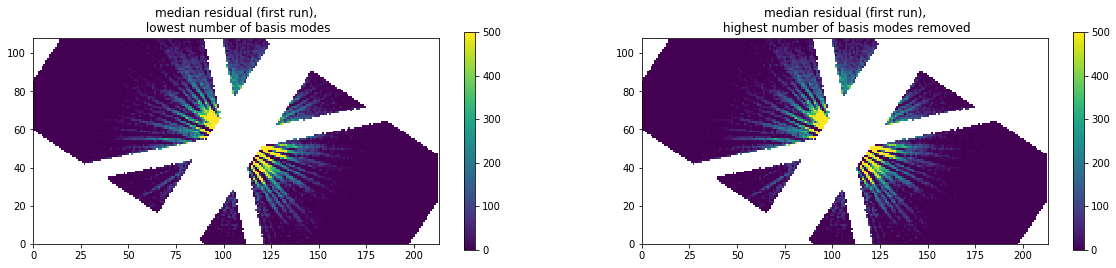

In [20]:
import matplotlib.pylab as plt
%matplotlib inline
plt.figure(figsize=[20,4])

plt.subplot(121)
plt.title("median residual (first run),\n lowest number of basis modes")
plt.imshow ( medianResidualPlot_yesRC1 [0,:,:],vmin=0,vmax=500 )
plt.xlim        ( [ 0, medianResidualPlot_yesRC1[0,:,:].shape[1] ] ) 
plt.ylim        ( [ 0, medianResidualPlot_yesRC1[0,:,:].shape[0] ] )
plt.colorbar()

plt.subplot(122)
plt.title("median residual (first run),\n highest number of basis modes removed")
plt.imshow ( medianResidualPlot_yesRC1 [-1,:,:],vmin=0,vmax=500 )
plt.xlim        ( [ 0, medianResidualPlot_yesRC1[-1,:,:].shape[1] ] ) 
plt.ylim        ( [ 0, medianResidualPlot_yesRC1[-1,:,:].shape[0] ] )
plt.colorbar()
plotName = runNumberString + "medres.png"

plt.savefig ( outputFolder + plotName , dpi = 150 )

In [21]:
outputFolderSplit = outputFolder.split('/')
logFilePrefix     = outputFolderSplit[1]
logFilesFromPrnft = glob.glob ( "logsFolder/*" )

for eachLogFile in logFilesFromPrnft : 
    if VL >= 3 : prntf("work",50,"eachLogFile : ", eachLogFile)
    eachLogFileBasename = os.path.basename ( eachLogFile )
    os.rename ("logsFolder/" + eachLogFileBasename, outputFolder + "/" + logFilePrefix + "_" + eachLogFileBasename)

if VL >= 3 : prntf("work",50,"outputFolder : ",outputFolder)
if VL >= 3 : prntf("work",20,"logFilePrefix : ", logFilePrefix)
if VL >= 3 : prntf("work",50,"logFilesFromPrnft : ", logFilesFromPrnft)    

In [22]:
for eachFile in os.listdir( outputFolder ) :
    print(eachFile)

yRC1_STG2-KLmodes-all.fits
182201_label_target_logfile.log
yRC1_medres.png
182201_label_target_logfile.txt
yRC1_cm.fits
